<div class="usecase-title">Analysing Melbourne's Urban Wellbeing Through Quality of Life Indicators</div>
<div class="usecase-authors">Author: Venkata Rama Kartikeya</div>

<div class="usecase-level-skill">
    <div class="usecase-level">Level: Intermediate</div>
    <div class="usecase-skill">Skills: Python, Pandas Exploratory Data Analysis, Data Visualisation</div>
</div>

<div class="usecase-duration">Duration: {90} minutes</div>

---

<div class="usecase-section-header">Scenario</div>

As a city planner in Melbourne, I want to analyse key quality of life indicators across different years and neighborhoods to:
- Identify areas needing improvement
- Measure the impact of urban policies
- Prioritise resources effectively
- Guide data-driven decisions to enhance resident wellbeing

---

<div class="usecase-section-header">What This Use Case Will Teach You</div>

- Access and analyse Melbourne's urban wellbeing datasets 
- Visualise trends in quality of life indicators
- Identify spatial patterns in city service performance
- Compare neighborhood performances by key metrics
- Generate actionable insights

---
<div class="usecase-section-header">Background / Introduction</div>

Melbourne's quality of life indicators provide crucial insights into the wellbeing of residents across different neighborhoods. These metrics help policymakers understand where interventions are needed most and track the effectiveness of urban programs over time.The data comes from Melbourne's Open Data Portal and includes annual measurements of safety, housing affordability, transport satisfaction, and other key livability factors. By analysing these indicators, we can identify both successful policies and areas requiring additional attention to maintain Melbourne's reputation as one of the world's most livable cities.

---

<h2 class="usecase-section-header"> Data Loading and Preparation </h2>


In [2]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium as fm
import geopandas as gpd
import requests
from io import StringIO
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage,dendrogram
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [3]:
# Set the style for visualisations
sns.set_theme(style='whitegrid',palette='colorblind')

<h2 div = "usecase-section-header"> Importing Data Through API

In [4]:
# Set the base URL and dataset ID for Melbourne Open Data

base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
dataset_id = 'indicators-of-quality-of-life-and-city-services-by-year'

 # Build the full export URL for CSV format

url = f'{base_url}{dataset_id}/exports/csv'

 # Define parameters for the API request

params = {

     'select': '*',
     'limit': -1,
     'lang': 'en',
     'timezone': 'UTC'

 }

 # Send request to the API
response = requests.get(url, params=params)
 
# Check if the request was successful
if response.status_code == 200:

     # Read the CSV content into a DataFrame
    url_content = response.content.decode('utf-8')
    df = pd.read_csv(StringIO(url_content), delimiter=';')

     # Print first 10 rows
    print(df.head(10))

else:
     # Print error message if request fails
    print(f'Request failed with status code {response.status_code}')



   number              indicator_theme                     indicator_variable  \
0     5.4                      Economy                   Full-time Employment   
1     5.7                      Economy                  Number of New Patents   
2     6.3                    Education         Secondary Education Completion   
3     7.1                       Energy             Residential Electrical Use   
4     7.7                       Energy         Electrical Interruption Length   
5    10.4  Fire and Emergency Response                 Volunteer Firefighters   
6    11.2                   Governance                Women Elected to Office   
7    12.6                       Health  Number of Mental Health Practitioners   
8    13.2                   Recreation               Outdoor Recreation Space   
9    14.3                       Safety              Number of Property Crimes   

                                indicator_descriptor        type  \
0       Percentage of persons in fulltim

<h2 class= "usecase-subsection-header"> Data Preprocessing </h2>

In [5]:
print(df.columns.tolist())

['number', 'indicator_theme', 'indicator_variable', 'indicator_descriptor', 'type', 'greater_melbourne_value', 'greater_melbourne_year', 'greater_melbourne_units', 'melbourne_municipality_value', 'melbourne_municipality_year', 'melbourne_municipality_units']


<h5 class ="usecase-section-header"> Removing Unwanted Columns

In [6]:
# Remove the 'Number' column 
df.drop(columns=["number"], inplace=True)
print(df.columns.tolist())

['indicator_theme', 'indicator_variable', 'indicator_descriptor', 'type', 'greater_melbourne_value', 'greater_melbourne_year', 'greater_melbourne_units', 'melbourne_municipality_value', 'melbourne_municipality_year', 'melbourne_municipality_units']


<h5 class = "usecase-section-header"> Arranging the dataset primarily on basis of indicator theme and by indicator variable in alphabetical order.


In [7]:
# Sort by 'Indicator theme' and then 'Indicator variable' in alphabetical order
df.sort_values(by=["indicator_theme", "indicator_variable"], ascending=[True, True], inplace=True)
df

,indicator_theme,indicator_variable,indicator_descriptor,type,greater_melbourne_value,greater_melbourne_year,greater_melbourne_units,melbourne_municipality_value,melbourne_municipality_year,melbourne_municipality_units
94,Economy,Commercial and Industrial Property Values,Assessed value of commercial and industrial pr...,Core,NaN,NaN,%,47.5365,2015.0,NaN
0,Economy,Full-time Employment,Percentage of persons in fulltime employment,Supporting,50.6319,2014.0,%,58.5449,2014.0,NaN
58,Economy,Number of Businesses,Number of businesses per 100 000 population,Supporting,3584.4199,2014.0,/100 000,11500.1596,2014.0,NaN
1,Economy,Number of New Patents,Number of new patents per 100 000 population p...,Supporting,13.6251,2014.0,/100 000/yr,84.2832,2014.0,NaN
24,Economy,Population Living in Poverty,Percentage of city population living in poverty,Core,8.2000,2014.0,%,11.0223,2014.0,NaN
...,...,...,...,...,...,...,...,...,...,...
34,Water and Sanitation,Improved Water Access,Percentage of city population with sustainable...,Core,100.0000,2014.0,%,100.0000,2014.0,NaN
63,Water and Sanitation,Potable Water Service,Percentage of city population with potable wat...,Core,100.0000,2014.0,%,100.0000,2014.0,NaN
57,Water and Sanitation,Total Water Consumption,Total water consumption per capita (litres/day),Supporting,226.6007,2014.0,L/d/capita,502.0710,2014.0,NaN
99,Water and Sanitation,Water Loss,Percentage of water loss (unaccounted for water),Supporting,10.6329,2014.0,%,10.6329,2014.0,NaN


<h5 class = "usecase-section-header"> Checking Missing Values

In [8]:
# Check for missing values in the dataset
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
indicator_theme                   0
indicator_variable                0
indicator_descriptor              0
type                              0
greater_melbourne_value          24
greater_melbourne_year           24
greater_melbourne_units           2
melbourne_municipality_value     13
melbourne_municipality_year      13
melbourne_municipality_units    100
dtype: int64


<h5 class= "usecase-subsection-header"> Handling missing values

<p class = "usecase-section-header"> In the cases where both the Greater Melbourne (Year) and Melbourne municipality (Year) are missing and any one of Greater Melbourne (Value) (or) Melbourne municipality (Value) is missing, we are removing the data because maximum number of highly necessary data columns are empty such data rows affect the data prediction with uneccessary deviations and it is very low chance to predict the exact values

In [9]:
df = df[~(
    df["greater_melbourne_year"].isna() &
    df["melbourne_municipality_year"].isna() &
    (df["greater_melbourne_value"].isna() | df["melbourne_municipality_value"].isna())
)]

<p class = "usecase-section-header"> Removing the rows where both are missing values because they can't be filled using mean, median or mode because there is no common factor in the indicator given wherein we could draw conclusion for one factor from another.But in this case every row indicates different scenario so they can't be replaced and must be removed.

In [10]:
df = df.dropna(subset=["greater_melbourne_value", "melbourne_municipality_value"], how="any")
print(df.isnull().sum())

indicator_theme                  0
indicator_variable               0
indicator_descriptor             0
type                             0
greater_melbourne_value          0
greater_melbourne_year           0
greater_melbourne_units          2
melbourne_municipality_value     0
melbourne_municipality_year      0
melbourne_municipality_units    72
dtype: int64


<p class = "usecase-section-header"> Replacing the missing values of Melbourne municipality (Units) with Greater Melbourne (Units) as the units would be same as we comparing same entity and it could be clearly understood according to the dataset given.After this there will still be 2 missing values as they are ratios and ratios have no units.

In [11]:
df["melbourne_municipality_units"] = df["melbourne_municipality_units"].astype(str)
df["melbourne_municipality_units"] = df["melbourne_municipality_units"].fillna(df["greater_melbourne_units"])

<p class = "usecase-section-header"> We replace empty values of Greater Melbourne (Year) with Melbourne municipality (Year) and vice-versa because the years of data would be same as they were recorded in the same year and that could be understood from the dataset.

In [12]:

# Fill missing values
df.loc[:, "greater_melbourne_year"] = df["greater_melbourne_year"].fillna(df["melbourne_municipality_year"])
df.loc[:, "melbourne_municipality_year"] = df["melbourne_municipality_year"].fillna(df["greater_melbourne_year"])

# Convert to nullable integers
df.loc[:, "greater_melbourne_year"] = df["greater_melbourne_year"].astype("Int64")
df.loc[:, "melbourne_municipality_year"] = df["melbourne_municipality_year"].astype("Int64")

# Check missing values
print("Missing values after filling:")
print(df.isnull().sum())

Missing values after filling:
indicator_theme                 0
indicator_variable              0
indicator_descriptor            0
type                            0
greater_melbourne_value         0
greater_melbourne_year          0
greater_melbourne_units         2
melbourne_municipality_value    0
melbourne_municipality_year     0
melbourne_municipality_units    0
dtype: int64


<p class = "usecase-section-header"> We have successful cleaned the data and the remaining 2 missing fields are ratios so they don't have any units.

<h5 class = "usecase-section-header" > Checking for duplicacy in the indicators so that it doesnt affect the analysis results...

In [13]:
# Check duplicates in "Indicator variable"
duplicates_variable = df[df.duplicated(subset=["indicator_variable"], keep=False)]

# Check duplicates in "Indicator descriptor"
duplicates_descriptor = df[df.duplicated(subset=["indicator_descriptor"], keep=False)]

print("Duplicate 'Indicator variable' entries:", duplicates_variable.shape[0])
print("Duplicate 'Indicator descriptor' entries:", duplicates_descriptor.shape[0])

Duplicate 'Indicator variable' entries: 0
Duplicate 'Indicator descriptor' entries: 0


<p class = "usecase-section-header"> So, This proves that our data is clean from duplicacy and is good to go...

In [14]:
df.info()
df.describe(include='all')
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 72 entries, 0 to 99
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   indicator_theme               72 non-null     object 
 1   indicator_variable            72 non-null     object 
 2   indicator_descriptor          72 non-null     object 
 3   type                          72 non-null     object 
 4   greater_melbourne_value       72 non-null     float64
 5   greater_melbourne_year        72 non-null     float64
 6   greater_melbourne_units       70 non-null     object 
 7   melbourne_municipality_value  72 non-null     float64
 8   melbourne_municipality_year   72 non-null     float64
 9   melbourne_municipality_units  72 non-null     object 
dtypes: float64(4), object(6)
memory usage: 6.2+ KB


indicator_theme                 0
indicator_variable              0
indicator_descriptor            0
type                            0
greater_melbourne_value         0
greater_melbourne_year          0
greater_melbourne_units         2
melbourne_municipality_value    0
melbourne_municipality_year     0
melbourne_municipality_units    0
dtype: int64

<h5 class = "use-case-header"> Normalising values using Z-Score

<p class = "use-case-header"> Without normalising the values cannot be used as they are from different units.

In [15]:
scaler = StandardScaler()
df[['greater_melbourne_scaled', 'melbourne_municipality_scaled']] = scaler.fit_transform(df[['greater_melbourne_value', 'melbourne_municipality_value']])
df ['z_diff'] = df['greater_melbourne_scaled'] - df['melbourne_municipality_scaled']

In [16]:
df

,indicator_theme,indicator_variable,indicator_descriptor,type,greater_melbourne_value,greater_melbourne_year,greater_melbourne_units,melbourne_municipality_value,melbourne_municipality_year,melbourne_municipality_units,greater_melbourne_scaled,melbourne_municipality_scaled,z_diff
0,Economy,Full-time Employment,Percentage of persons in fulltime employment,Supporting,50.6319,2014.0,%,58.5449,2014.0,nan,-0.226192,-0.255340,0.029148
58,Economy,Number of Businesses,Number of businesses per 100 000 population,Supporting,3584.4199,2014.0,/100 000,11500.1596,2014.0,nan,-0.027213,0.370916,-0.398129
1,Economy,Number of New Patents,Number of new patents per 100 000 population p...,Supporting,13.6251,2014.0,/100 000/yr,84.2832,2014.0,nan,-0.228276,-0.253931,0.025656
24,Economy,Population Living in Poverty,Percentage of city population living in poverty,Core,8.2000,2014.0,%,11.0223,2014.0,nan,-0.228581,-0.257941,0.029360
12,Economy,Unemployment Rate,City's unemployment rate,Core,6.6497,2014.0,%,5.0346,2014.0,nan,-0.228669,-0.258269,0.029600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,Water and Sanitation,Improved Sanitation Access,Percentage of population with access to improv...,Core,100.0000,2014.0,%,100.0000,2015.0,nan,-0.223412,-0.253071,0.029659
34,Water and Sanitation,Improved Water Access,Percentage of city population with sustainable...,Core,100.0000,2014.0,%,100.0000,2014.0,nan,-0.223412,-0.253071,0.029659
63,Water and Sanitation,Potable Water Service,Percentage of city population with potable wat...,Core,100.0000,2014.0,%,100.0000,2014.0,nan,-0.223412,-0.253071,0.029659
57,Water and Sanitation,Total Water Consumption,Total water consumption per capita (litres/day),Supporting,226.6007,2014.0,L/d/capita,502.0710,2014.0,nan,-0.216284,-0.231064,0.014780


<h2 class="usecase-subsection-header">Exploratory Data Analysis</h2>

<h5 class= use-case-header> Indicator distibution by Various Factors

<p class ="use-class-header"> By Theme - This is crucial for understanding which areas of theme of indicators are mostly measured or least measured

In [17]:
theme_counts = df['indicator_theme'].value_counts()
print(theme_counts)

indicator_theme
Transportation                      9
Solid Waste                         8
Health                              7
Economy                             6
Water and Sanitation                6
Environment                         5
Finance                             4
Governance                          4
Safety                              4
Wastewater                          4
Education                           3
Energy                              3
Shelter                             3
Fire and Emergency Response         2
Telecommunication and Innovation    2
Urban Planning                      2
Name: count, dtype: int64


<p class = "use-case-header"> From the above it is very clear that Transportation,Solid Waste and Health themes were more dominant in the dataset and Fire and Emergency Response,Telecommunication and Innovation,Urban Planning were given a lower representation.

<p class ="use-case-header"> By Core v/s Supporting Indicator - This is because core indicators are more crucial than Supporting Indicator in prioritising trends and regional comparison

In [18]:
type_distribution = df['type'].value_counts()
print(type_distribution)

type
Supporting    36
Core          36
Name: count, dtype: int64


<p class = "use-case-header"> From the above we can understand that both core and supporting data were given equal importance in representing various theme fields.

<h5 class ="use-case-header"> Top 10 indicators where Greater Melbourne overperforms.

In [19]:
top_positive = df.sort_values(by='z_diff', ascending=False).head(10)
print("Top 10 indicators where Greater Melbourne overperforms:")
print(top_positive[['indicator_theme','indicator_variable', 'z_diff']])

Top 10 indicators where Greater Melbourne overperforms:
                     indicator_theme              indicator_variable    z_diff
77                    Transportation     Commercial Air Connectivity  0.209365
92  Telecommunication and Innovation          Cell Phone Connections  0.163077
20  Telecommunication and Innovation            Internet Connections  0.113847
2                          Education  Secondary Education Completion  0.030841
72                       Solid Waste            Solid Waste Recycled  0.030815
23              Water and Sanitation      Domestic Water Consumption  0.030707
68                        Governance        Voter Participation Rate  0.030103
13                           Economy         Youth Unemployment Rate  0.029696
65                           Finance                Capital Spending  0.029662
34              Water and Sanitation           Improved Water Access  0.029659


<h5 class ="use-case-header"> Top 10 indicators where Greater Melbourne underperforms.

In [20]:
top_negative = df.sort_values(by='z_diff').head(10)
print("Top 10 indicators where Greater Melbourne underperforms:")
print(top_negative[['indicator_theme','indicator_variable', 'z_diff']])

Top 10 indicators where Greater Melbourne underperforms:
         indicator_theme                     indicator_variable    z_diff
60             Education               Higher Education Degrees -1.036979
58               Economy                   Number of Businesses -0.398129
9                 Safety              Number of Property Crimes -0.317873
29                Health              Number of Nurses/Midwives -0.190360
96                Health                   Number of Physicians -0.087301
49                Safety               Number of Violent Crimes -0.067886
18                Health               In-Patient Hospital Beds -0.066539
75        Transportation                   Public Transit Trips -0.021135
7                 Health  Number of Mental Health Practitioners -0.019594
57  Water and Sanitation                Total Water Consumption  0.014780


<h5 class = "use-case-header"> Plotting Overperforming Indicators of Greater Melbourne 

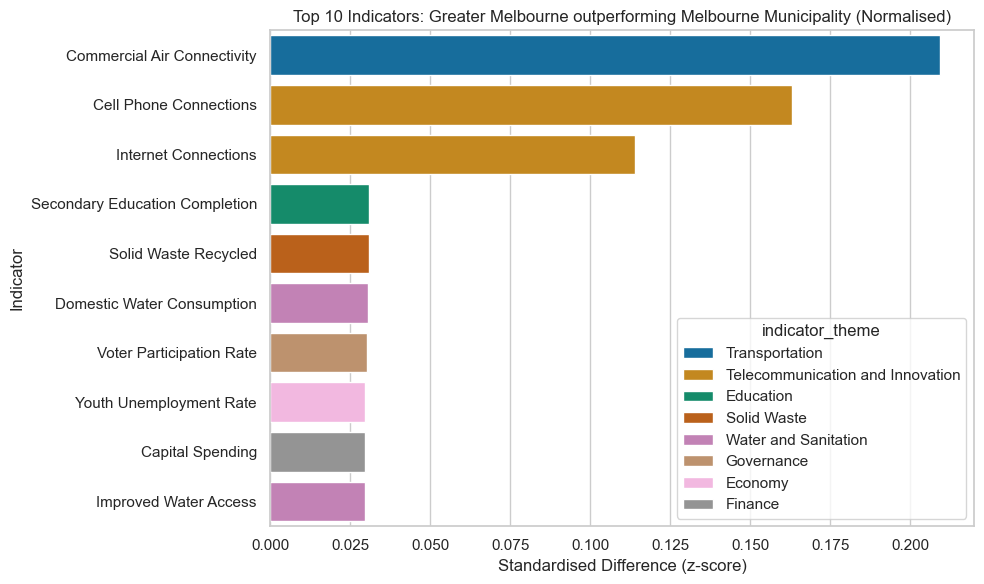

In [21]:
plt.figure(figsize=(10, 6))
sns.barplot(data=top_positive, x='z_diff', y='indicator_variable', hue='indicator_theme', dodge=False)
plt.title("Top 10 Indicators: Greater Melbourne outperforming Melbourne Municipality (Normalised)")
plt.xlabel("Standardised Difference (z-score)")
plt.ylabel("Indicator")
plt.tight_layout()
plt.show()

<h5 class = "use-case-header"> Plotting Underperforming Indicators of Greater Melbourne 

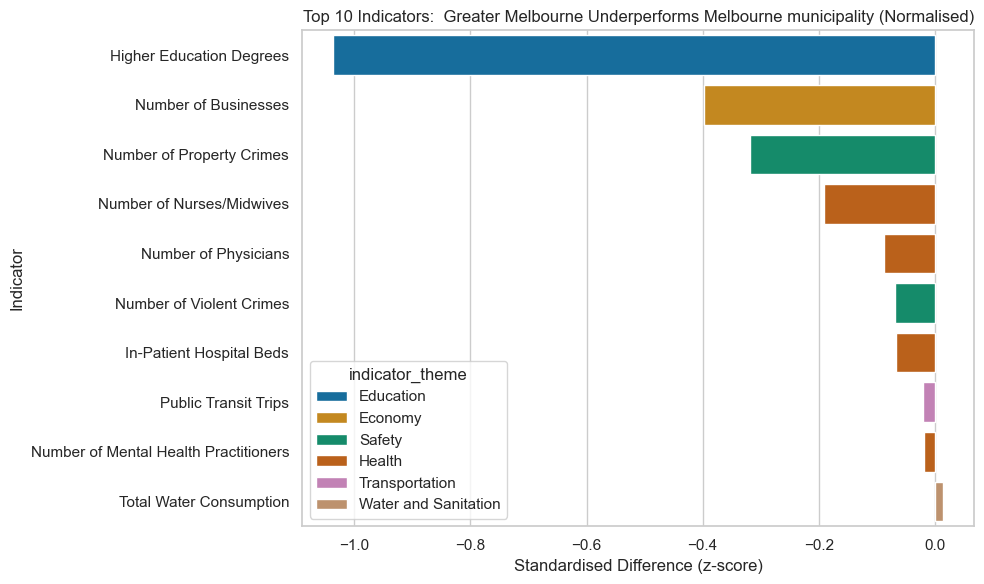

In [30]:

plt.figure(figsize=(10, 6))
sns.barplot(data=top_negative, x='z_diff', y='indicator_variable', hue='indicator_theme', dodge=False)
plt.title("Top 10 Indicators:  Greater Melbourne Underperforms Melbourne municipality (Normalised)")
plt.xlabel("Standardised Difference (z-score)")
plt.ylabel("Indicator")
plt.tight_layout()
plt.show()

<h5 class = "use-case-header"> Having a Deep dive into Top 5 Theme based Indicators.

<p class = "use-case-header"> Top 5 Theme that are very fundamental essential for wellbeing that I have chosen for comparison are -

- Health 
- Water and Sanitation
- Environment
- Finance
- Safety

<p class = "use-case-header"> Health Theme Comparison

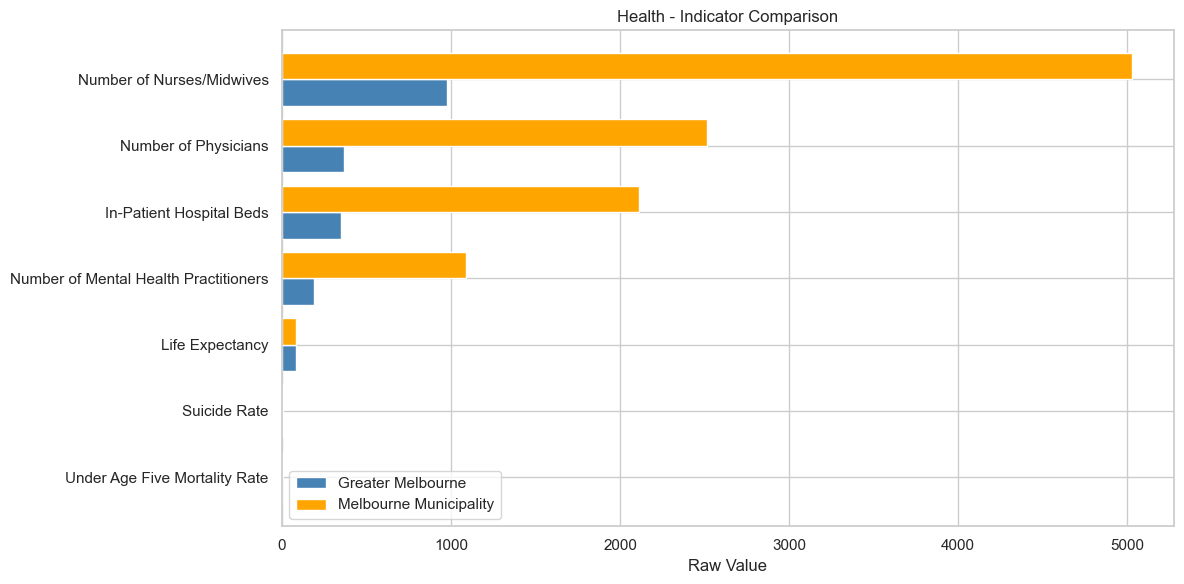

In [23]:
# Health Theme Comparison
health_df = df[df['indicator_theme'] == 'Health'].sort_values(by='greater_melbourne_value', ascending=False)

plt.figure(figsize=(12, 6))
x = range(len(health_df))
bar_width = 0.4

plt.barh([i + bar_width for i in x], health_df['greater_melbourne_value'], height=bar_width, label='Greater Melbourne', color='steelblue')
plt.barh(x, health_df['melbourne_municipality_value'], height=bar_width, label='Melbourne Municipality', color='orange')

plt.yticks([i + bar_width / 2 for i in x], health_df['indicator_variable'])
plt.title("Health - Indicator Comparison")
plt.xlabel("Raw Value")
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

<p class = "use-case-header"> Water and Sanitation Theme Comparison

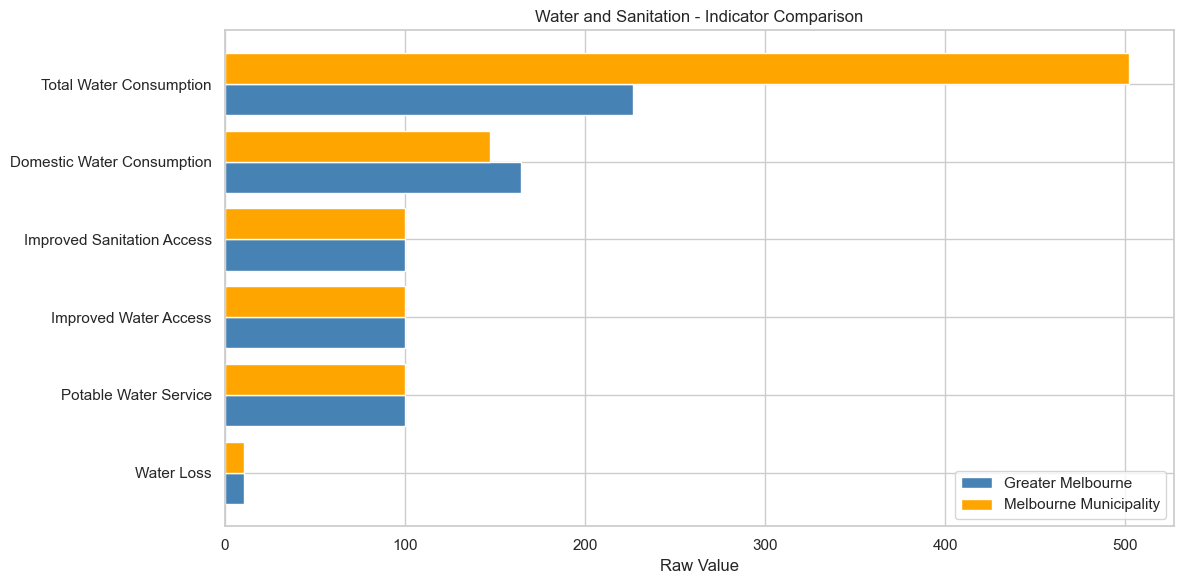

In [24]:
# Water and Sanitation Theme Comparison
water_df = df[df['indicator_theme'] == 'Water and Sanitation'].sort_values(by='greater_melbourne_value', ascending=False)

plt.figure(figsize=(12, 6))
x = range(len(water_df))
bar_width = 0.4

plt.barh([i + bar_width for i in x], water_df['greater_melbourne_value'], height=bar_width, label='Greater Melbourne', color='steelblue')
plt.barh(x, water_df['melbourne_municipality_value'], height=bar_width, label='Melbourne Municipality', color='orange')

plt.yticks([i + bar_width / 2 for i in x], water_df['indicator_variable'])
plt.title("Water and Sanitation - Indicator Comparison")
plt.xlabel("Raw Value")
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


<p class = "use-case-header"> Environment Theme Comparison

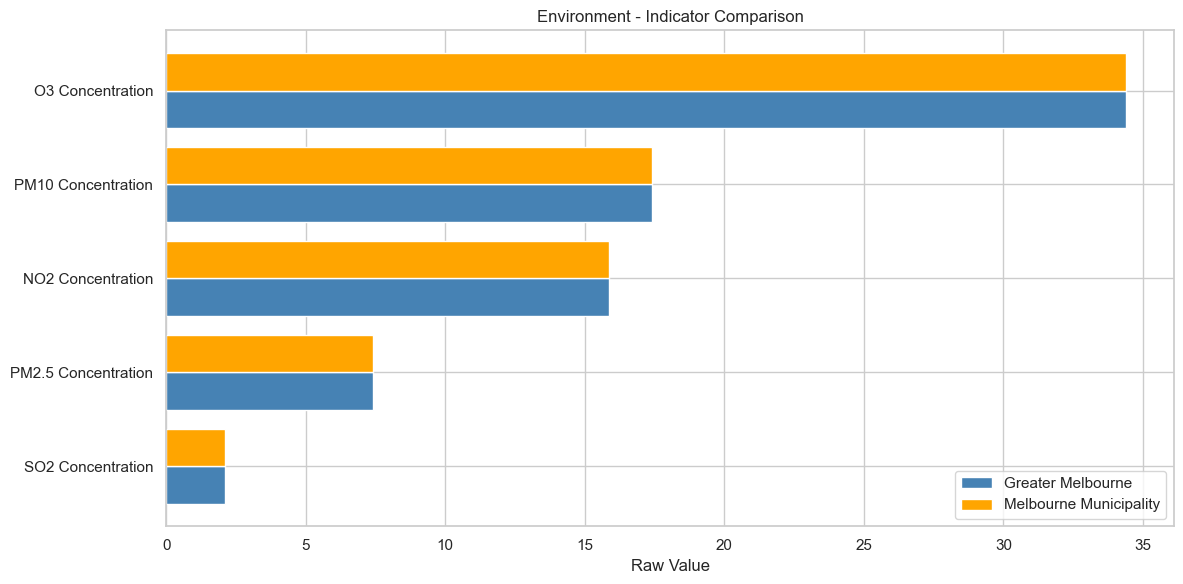

In [25]:
# Environment Theme Comparison
environment_df = df[df['indicator_theme'] == 'Environment'].sort_values(by='greater_melbourne_value', ascending=False)

plt.figure(figsize=(12, 6))
x = range(len(environment_df))
bar_width = 0.4

plt.barh([i + bar_width for i in x], environment_df['greater_melbourne_value'], height=bar_width, label='Greater Melbourne', color='steelblue')
plt.barh(x, environment_df['melbourne_municipality_value'], height=bar_width, label='Melbourne Municipality', color='orange')

plt.yticks([i + bar_width / 2 for i in x], environment_df['indicator_variable'])
plt.title("Environment - Indicator Comparison")
plt.xlabel("Raw Value")
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


<p class = "use-case-header"> Finance Theme Comparison

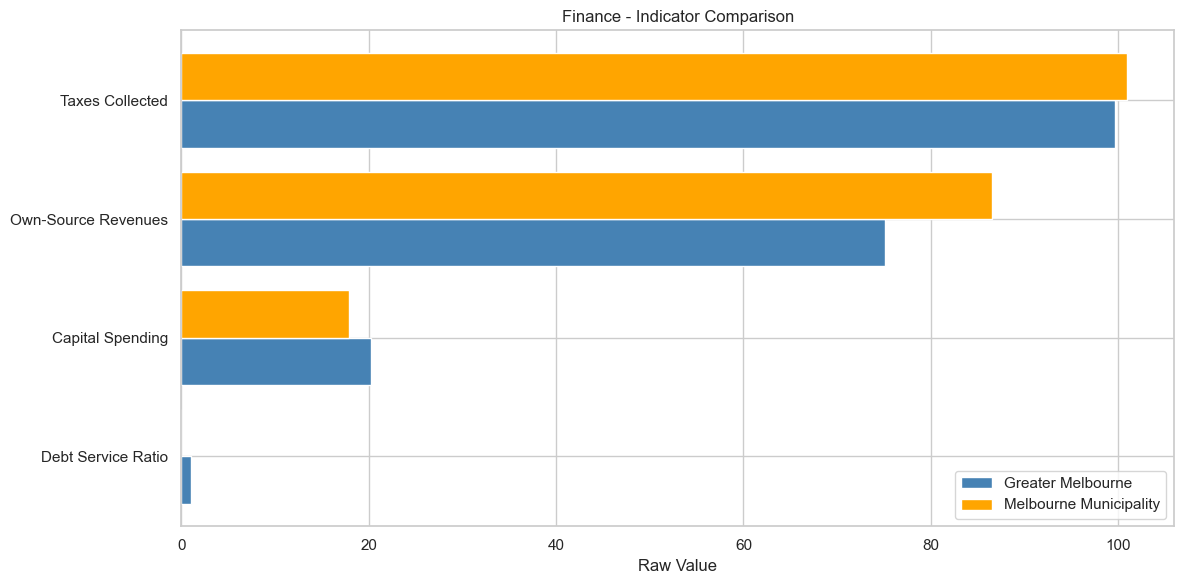

In [26]:
# Finance Theme Comparison
finance_df = df[df['indicator_theme'] == 'Finance'].sort_values(by='greater_melbourne_value', ascending=False)

plt.figure(figsize=(12, 6))
x = range(len(finance_df))
bar_width = 0.4

plt.barh([i + bar_width for i in x], finance_df['greater_melbourne_value'], height=bar_width, label='Greater Melbourne', color='steelblue')
plt.barh(x, finance_df['melbourne_municipality_value'], height=bar_width, label='Melbourne Municipality', color='orange')

plt.yticks([i + bar_width / 2 for i in x], finance_df['indicator_variable'])
plt.title("Finance - Indicator Comparison")
plt.xlabel("Raw Value")
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


<p class = "use-case-header"> Safety Theme Comparison

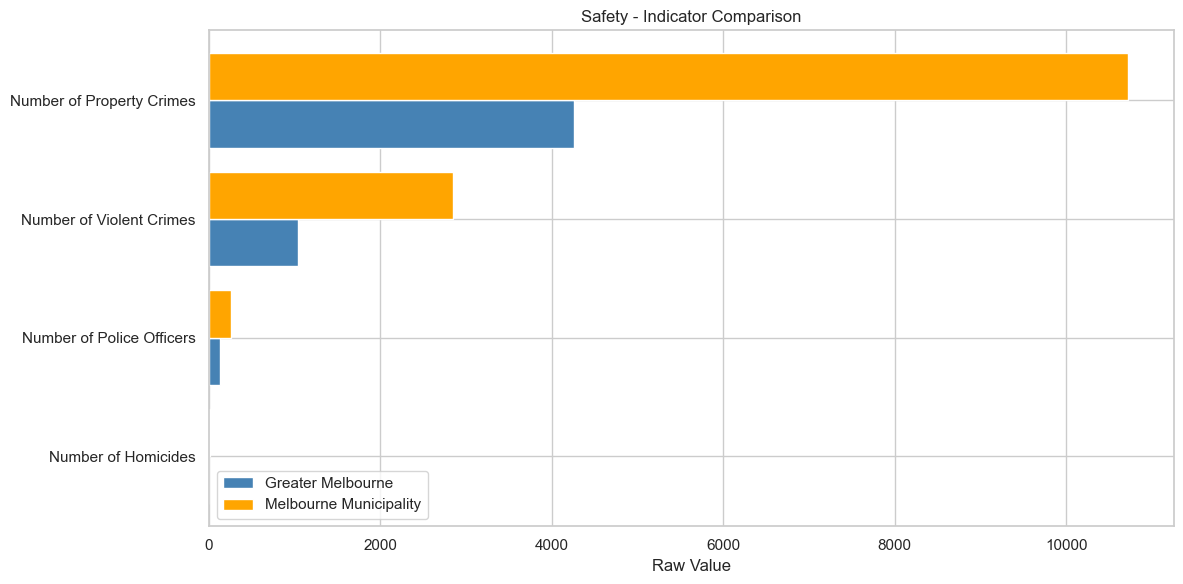

In [27]:
# Safety Theme Comparison
safety_df = df[df['indicator_theme'] == 'Safety'].sort_values(by='greater_melbourne_value', ascending=False)

plt.figure(figsize=(12, 6))
x = range(len(safety_df))
bar_width = 0.4

plt.barh([i + bar_width for i in x], safety_df['greater_melbourne_value'], height=bar_width, label='Greater Melbourne', color='steelblue')
plt.barh(x, safety_df['melbourne_municipality_value'], height=bar_width, label='Melbourne Municipality', color='orange')

plt.yticks([i + bar_width / 2 for i in x], safety_df['indicator_variable'])
plt.title("Safety - Indicator Comparison")
plt.xlabel("Raw Value")
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


<h5 class = "use-case-header"> Correlation between Indicator theme and Indicator variable

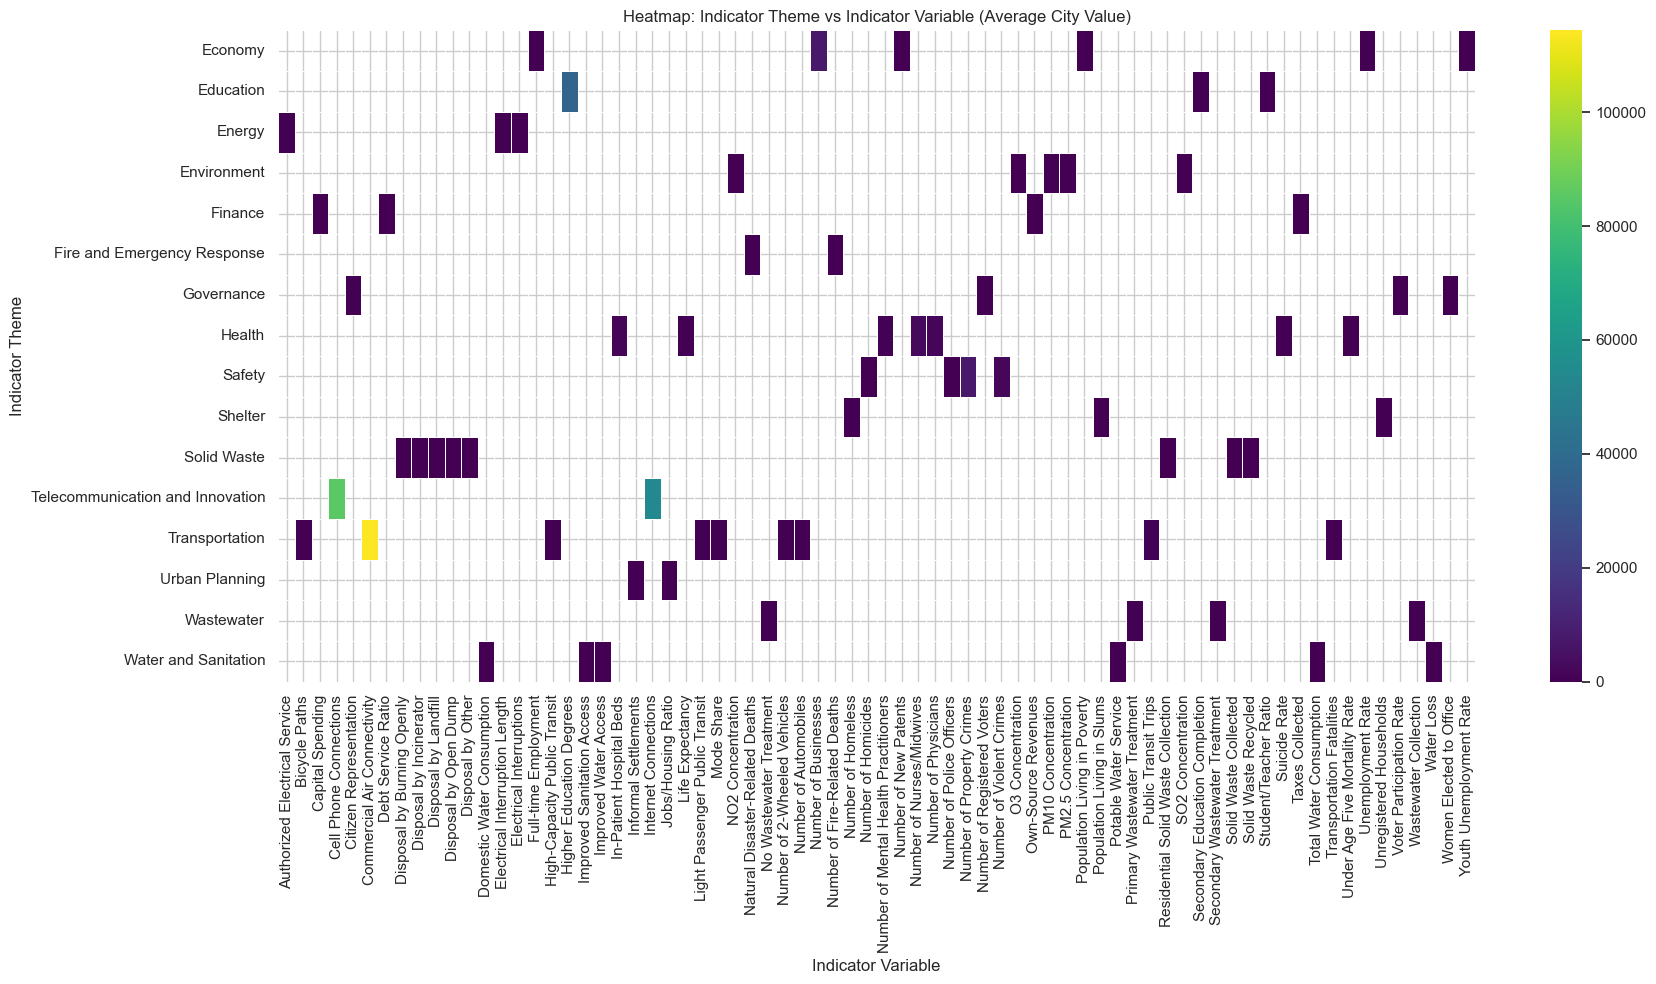

In [28]:
# Average both cities to get a unified value
df['average_value'] = (df['greater_melbourne_value'] + df['melbourne_municipality_value']) / 2

# Pivot table - indicator_theme (rows) vs indicator_variable (columns)
pivot = df.pivot_table(index='indicator_theme', columns='indicator_variable', values='average_value')

# Plot heatmap
plt.figure(figsize=(18, 10))
sns.heatmap(pivot, cmap='viridis', annot=False, linewidths=0.5)
plt.title("Heatmap: Indicator Theme vs Indicator Variable (Average City Value)")
plt.xlabel("Indicator Variable")
plt.ylabel("Indicator Theme")
plt.tight_layout()
plt.show()